In [20]:
import h5py
import numpy as np
import operator
import visualisation
import pandas as pd
import matplotlib.pyplot as plt
from dtw import dtw

from sporco import plot, util
from sporco.admm import cbpdn
from sporco.dictlrn import cbpdndl
from numpy.fft import rfft, rfftfreq
from itertools import tee

import scipy.signal as sg

plt.rcParams["figure.figsize"] = (16,8)


## Load the data

In [2]:
PATH_TO_TRAINING_DATA = "additional_files_dreem/X_train_denoised_array.h5"
PATH_TO_TRAINING_TARGET = "data/y_train_tX9Br0C.csv"
h5_file = h5py.File(PATH_TO_TRAINING_DATA)
mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))

/Users/Claudia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
X_train = np.array(h5_file.get('data'))

Separation of signals containing at least one apnea event and those who are completely normal sleep.

In [4]:
idx_apnea_signals = []
idx_normal_signals = []
for i in range(4400):
    if 1 in mask[i,1:]:
        idx_apnea_signals += [i]
    else:
        idx_normal_signals += [i]

## Exploration of respiratory signals for a normal sleep

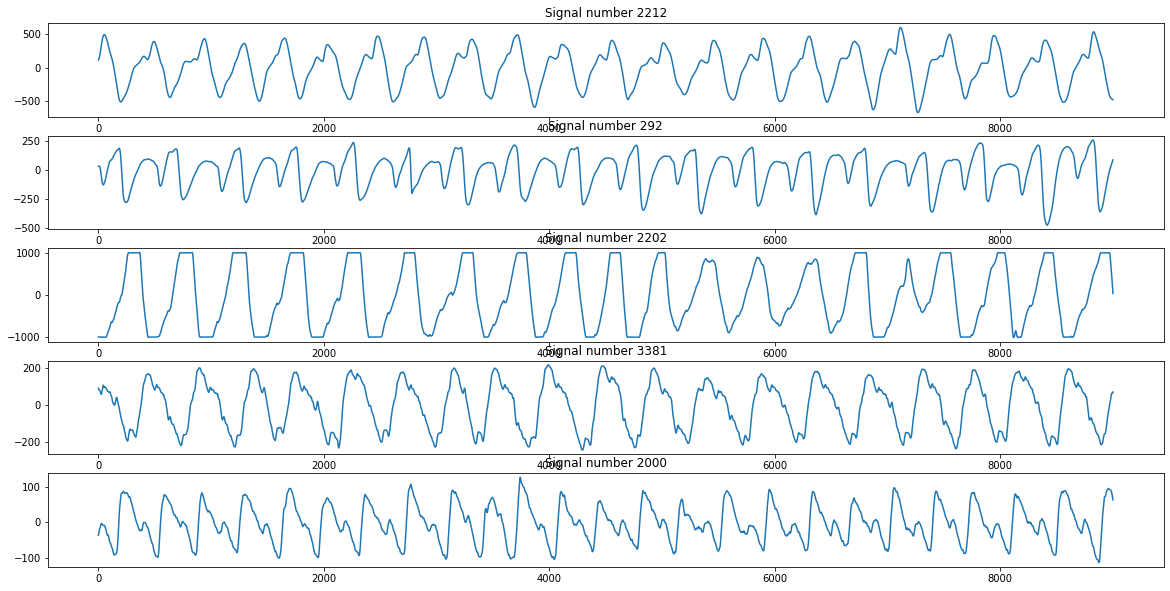

In [5]:
n_signals = 5
chosen_signals = np.random.randint(len(idx_normal_signals),size=n_signals)

fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[0,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

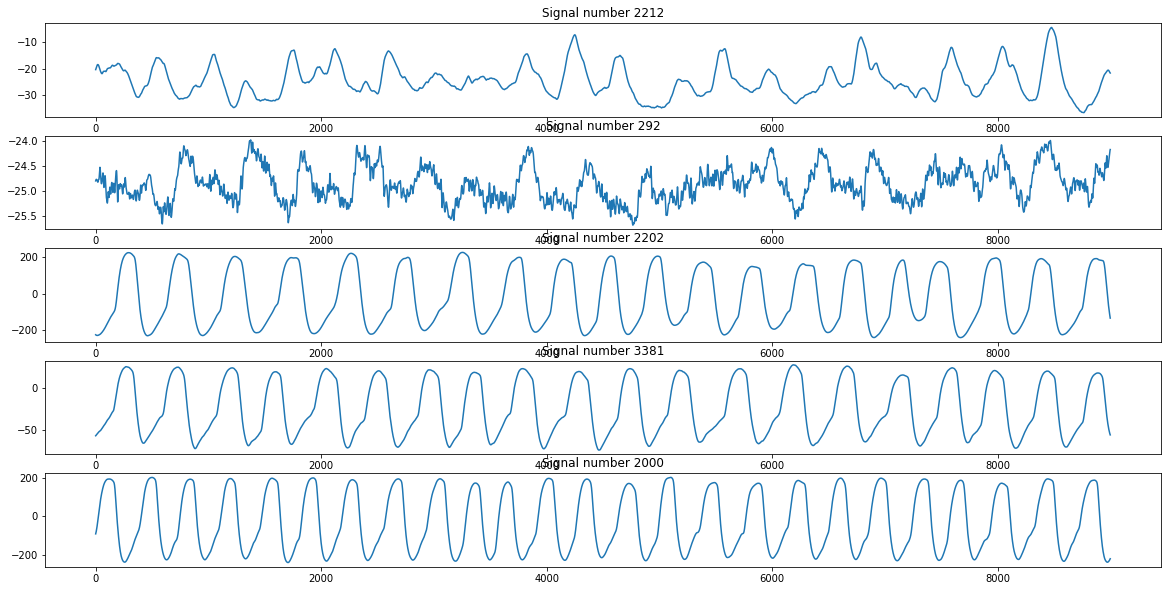

In [6]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[1,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

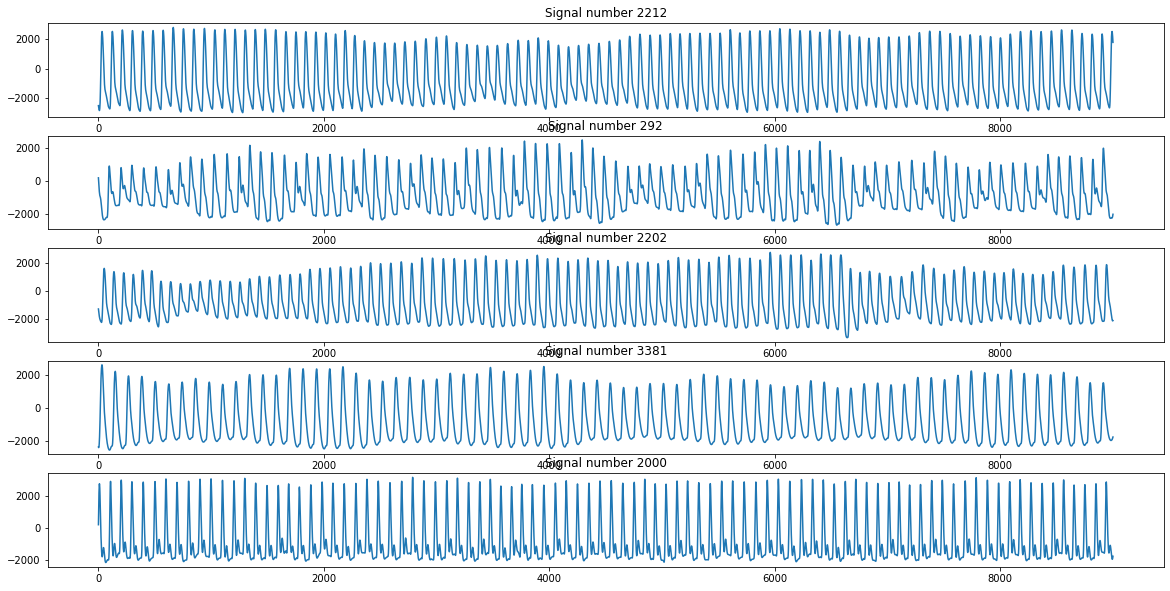

In [7]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[2,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

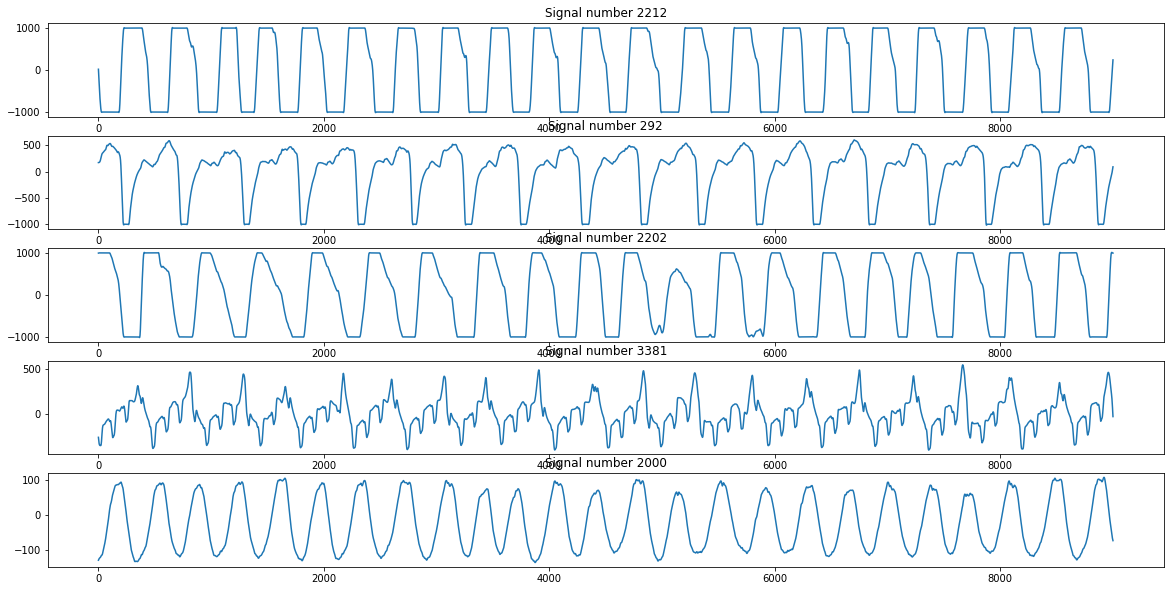

In [8]:
fig, ax = plt.subplots(nrows=n_signals, figsize=(20,10))
for i in range(n_signals):
    ax[i].plot(X_train[3,idx_normal_signals[chosen_signals[i]]])
    ax[i].set_title(f"Signal number {chosen_signals[i]}")

## Utility functions for CDL

In [9]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [10]:
def atleast_2d(ary):
    """Reshape array to at least two dimensions."""
    if ary.ndim == 0:
        return ary.reshape(1, 1)
    elif ary.ndim == 1:
        return ary[:, np.newaxis]
    return ary

In [11]:
def display_distance_matrix_as_table(
    distance_matrix, labels=None, figsize=(8, 2)
):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("tight")
    ax.axis("off")
    norm = mpl.colors.Normalize()
    cell_colours_hex = np.empty(shape=distance_matrix.shape, dtype=object)
    cell_colours_rgba = plt.get_cmap("magma")(norm(distance_matrix))

    for i in range(distance_matrix.shape[0]):
        for j in range(i + 1, distance_matrix.shape[0]):
            cell_colours_hex[i, j] = rgb2hex(
                cell_colours_rgba[i, j], keep_alpha=True
            )
            cell_colours_hex[j, i] = cell_colours_hex[i, j]

    if labels is not None:
        _ = ax.table(
            cellText=distance_matrix,
            colLabels=labels,
            rowLabels=labels,
            loc="center",
            cellColours=cell_colours_hex,
        )
    else:
        _ = ax.table(
            cellText=distance_matrix,
            loc="center",
            cellColours=cell_colours_hex,
        )

    return ax

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

## CDL on a single signal

For a 1D signal $\mathbf{x}\in\mathbb{R}^N$ with $N$ samples, the convolutional dictionary learning tasks amounts to solving the following optimization problem:

$$
\min_{(\mathbf{d}_k)_k, (\mathbf{z}_k)_k \\ \lVert\mathbf{d}_k\rVert^2\leq 1} \quad\left\lVert \mathbf{x} - \sum_{k=1}^K \mathbf{z}_k * \mathbf{d}_k \right\rVert^2 \quad + \quad\lambda \sum_{k=1}^K \lVert\mathbf{z}_k\rVert_1
$$

where $\mathbf{d}_k\in\mathbb{R}^L$ are the $K$ dictionary atoms (patterns), $\mathbf{z}_k\in\mathbb{R}^{N-L+1}$ are activations signals, and $\lambda>0$ is the sparsity constraint.

This problem is not convex with respect to the couple $(\mathbf{d}_k)_k, (\mathbf{z}_k)_k$ but convex when the subproblems are taken individually.

In [12]:
# In this cell, we set parameters and options that should probably remained unchanged
PENALTY = 3

# options for the dictionary learning and sparse coding procedures
def get_opt_dl(penalty=PENALTY):
    """Return the option class for the dictionary learning"""
    return cbpdndl.ConvBPDNDictLearn.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "CBPDN": {"rho": 50.0 * penalty + 0.5, "NonNegCoef": True},
            "CCMOD": {"rho": 10.0},
        },
        dmethod="cns",
    )


def get_opt_sc():
    """Return the option class for the sparse coding"""
    return cbpdn.ConvBPDN.Options(
        {
            "Verbose": False,
            "MaxMainIter": 50,
            "RelStopTol": 5e-3,
            "AuxVarObj": False,
            "NonNegCoef": True,  # only positive sparse codes
        }
    )

Let's apply dictionary learning on the first normal signal.

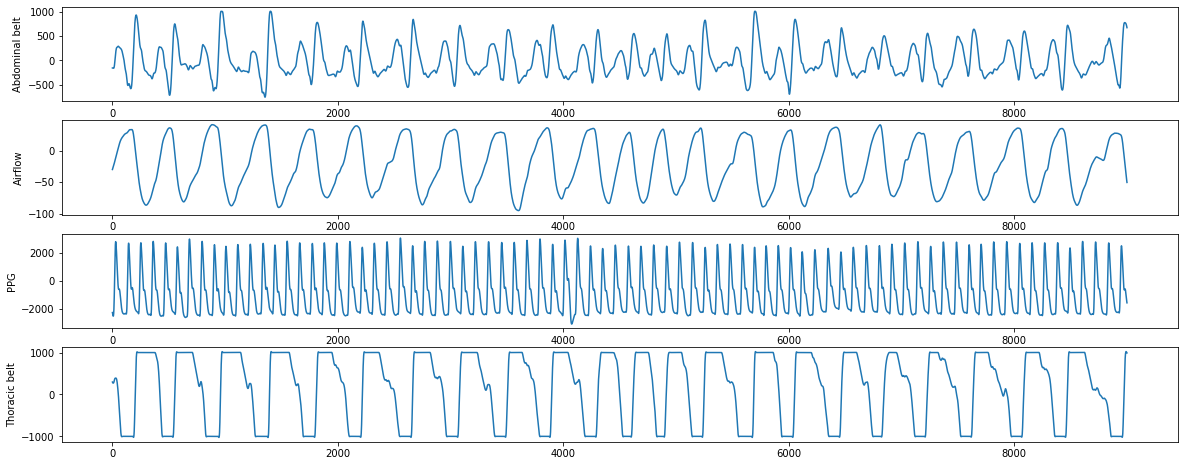

In [13]:
labels = ["Abdominal belt", "Airflow", "PPG", "Thoracic belt", "Snoring indicator", "SPO2", "C4-A1", "O2-A1"]

fig, ax = plt.subplots(nrows=4, figsize=(20,8))
for i in range(4):
    ax[i].plot(X_train[i, idx_normal_signals[1]])
    ax[i].set_ylabel(labels[i])

In [14]:
# Parameters to change
n_atoms = 3
atom_length = 500
penalty = 4

# Select a signal
signal = X_train[1, idx_normal_signals[0]]
signal = atleast_2d(signal)  # reshape

# Random number generator
rng = np.random.RandomState(seed=123)

In [15]:
# get options for the optimizations
opt_dl = get_opt_dl(penalty=penalty)
opt_sc = get_opt_sc()

# Dictionary learning and sparse coding
dict_learning = cbpdndl.ConvBPDNDictLearn(
    D0=rng.randn(atom_length, 1, n_atoms),  # random init
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_dl,  # options for the optimizations
    xmethod="admm",  # optimization method (sparse coding)
    dmethod="cns",  # optimization method (dict learnin)
)
atom_dictionary = dict_learning.solve()

# retrieve the sparse codes
basis_pursuit = cbpdn.ConvBPDN(
    D=atom_dictionary,  # learned dictionary
    S=signal,  # signal at hand
    lmbda=penalty,  # sparsity penalty
    opt=opt_sc,  # options for the optimizations
)
sparse_codes = basis_pursuit.solve().squeeze()

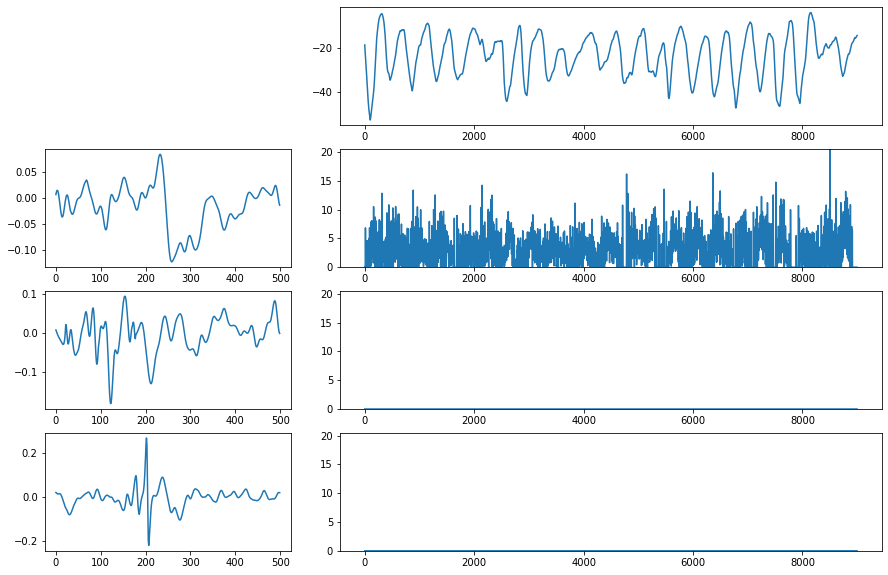

In [16]:
plot_CDL(
    signal, atleast_2d(sparse_codes), atleast_2d(atom_dictionary.squeeze())
)

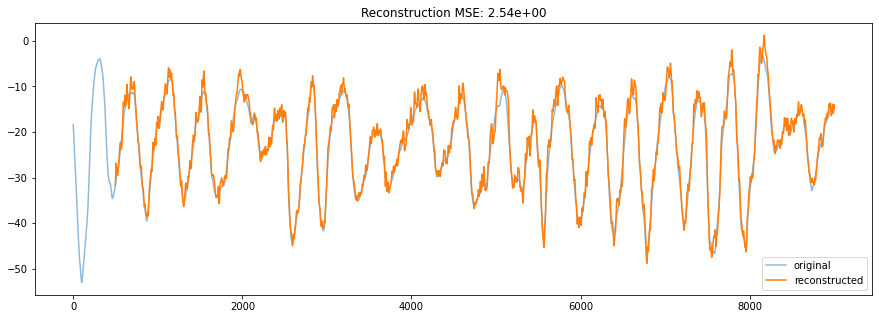

In [17]:
# Reconstruction with the dictionary and the sparse codes
reconstruction = np.stack(
    [
        np.convolve(code, atom, mode="valid")
        for (code, atom) in zip(
            atleast_2d(sparse_codes).T, atleast_2d(atom_dictionary.squeeze()).T
        )
    ],
    axis=0,
)

# Note that the reconstruction has less samples than the original signal.
# This is because of border effects of the convolution.
offset = atom_length - 1

fig, ax = fig_ax()
tt = np.arange(signal.shape[0])
ax.plot(tt, signal, label="original", alpha=0.5)
ax.plot(tt[offset:], reconstruction.sum(axis=0), label="reconstructed")
ax.set_title(
    f"Reconstruction MSE: {np.mean((signal[offset :].flatten() - reconstruction.sum(axis=0))**2):.2e}"
)
_ = plt.legend()

Finding a dictionary is hard.
Let's use peaks

In [22]:
def keep_peaks(peaks, treshold):
    time_diff_peaks = (peaks[1:] - peaks[:-1])/100.
    #plt.hist(time_diff_peaks,10)
    drop_values = np.where(time_diff_peaks < treshold)[0]
    time_diff_peaks = np.delete(time_diff_peaks, drop_values)
    return(np.delete(peaks,drop_values+1), time_diff_peaks)

Signal 0
Average interval between peaks : 3.79, var : 0.13, median : 3.82, min : 3.36, max : 4.54  
Signal 1
Average interval between peaks : 4.18, var : 0.10, median : 4.23, min : 3.68, max : 4.78  
Signal 2
Average interval between peaks : 1.19, var : 0.00, median : 1.19, min : 1.16, max : 1.22  
Signal 3
Average interval between peaks : 3.81, var : 0.95, median : 4.19, min : 0.85, max : 4.66  


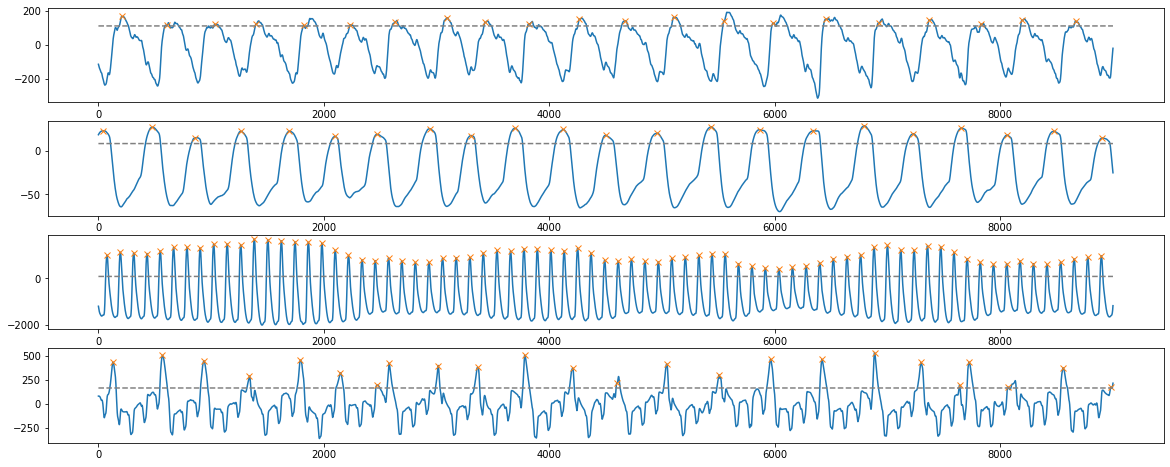

In [24]:
signal_id = idx_normal_signals[3383]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    ax[i].plot(peaks, signal_i[peaks], "x")
    
    ax[i].plot(np.zeros_like(signal_i)+ treshold, "--", color="gray")

Signal 0
Average interval between peaks : 2.64, var : 1.08, median : 2.70, min : 1.15, max : 4.42  
Signal 1
Average interval between peaks : 3.92, var : 0.19, median : 3.95, min : 2.99, max : 4.71  
Signal 2
Average interval between peaks : 1.12, var : 0.00, median : 1.12, min : 1.02, max : 1.18  
Signal 3
Average interval between peaks : 2.77, var : 0.23, median : 2.88, min : 1.90, max : 3.70  


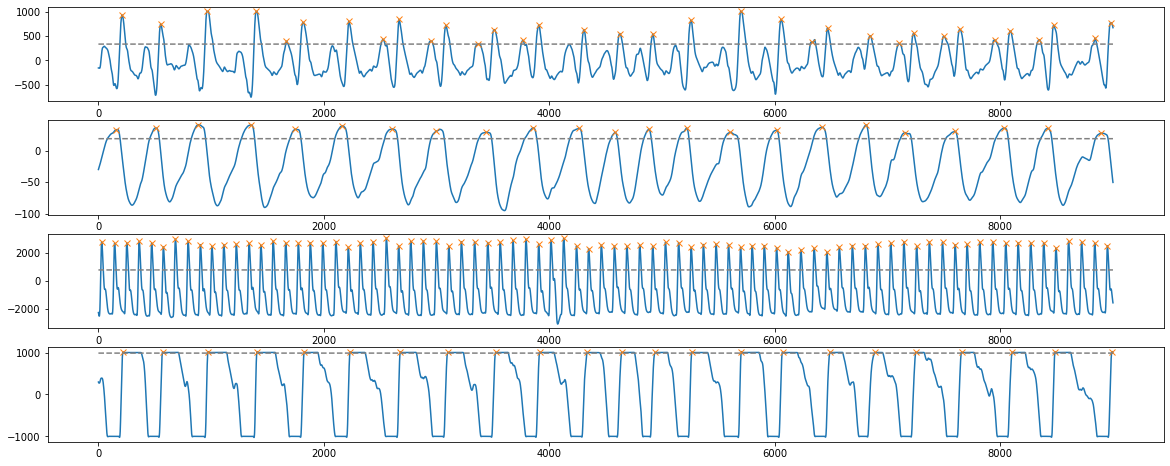

In [25]:
signal_id = idx_normal_signals[1]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    signal_i = X_train[i, signal_id]
    treshold = signal_i.mean()+ signal_i.std()
    ax[i].plot(signal_i)
    peaks, _ = sg.find_peaks(signal_i,height= treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")

Signal 0
Average interval between peaks : 6.42, var : 0.00, median : 6.42, min : 6.42, max : 6.42  
Signal 1
Average interval between peaks : 4.78, var : 10.04, median : 4.09, min : 3.28, max : 17.77  
Signal 2
Average interval between peaks : 0.77, var : 0.02, median : 0.76, min : 0.68, max : 2.05  
Signal 3
Average interval between peaks : 4.22, var : 10.35, median : 3.38, min : 2.70, max : 16.89  


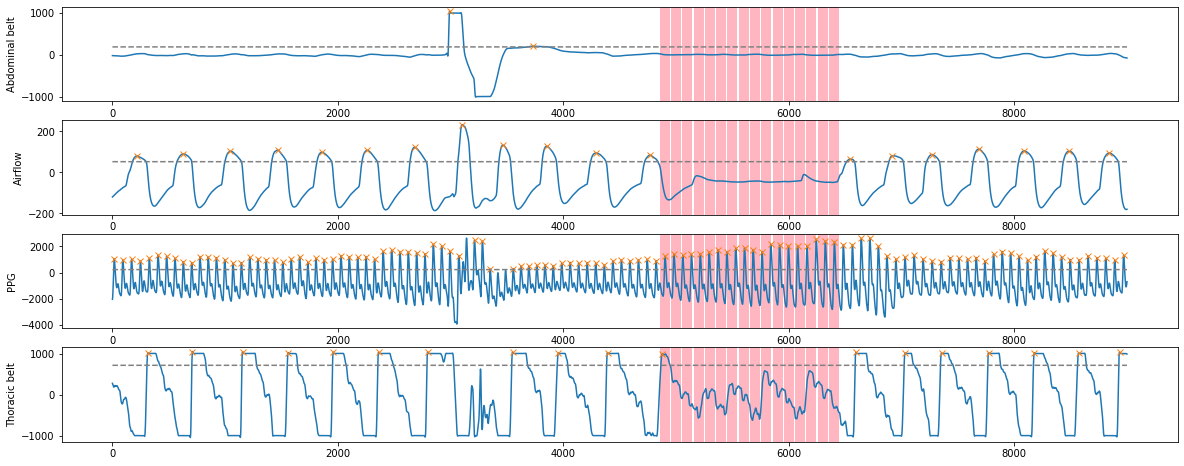

In [26]:
signal_id = idx_apnea_signals[37]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

3.668823529411765
3.77
1.306029411764706
4.154444444444445


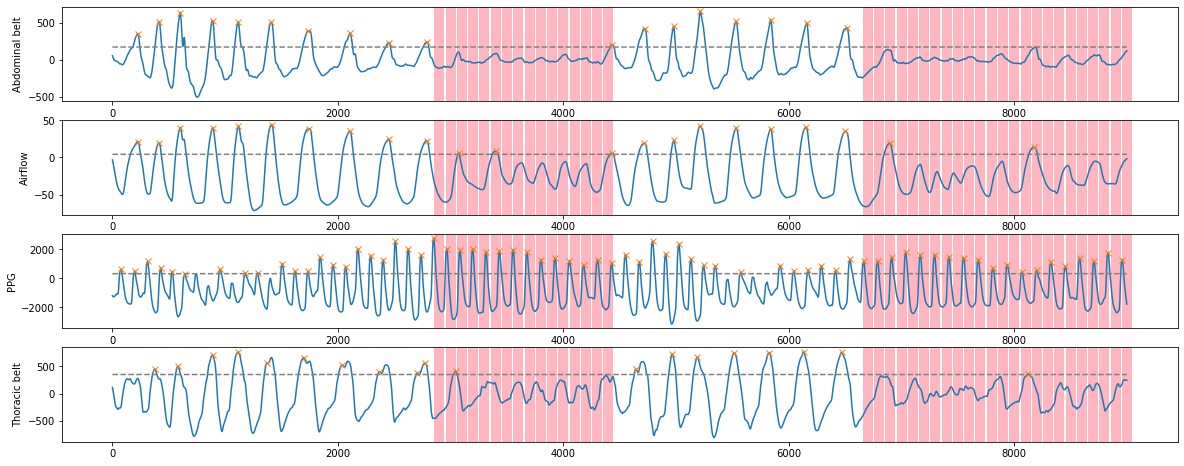

In [261]:
signal_id = idx_apnea_signals[100]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, mean = keep_peaks(peaks, 0.6)
    print(mean)
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

Signal 0
Average interval between peaks : 3.92, var : 12.98, median : 2.54, min : 1.86, max : 14.39  
Signal 1
Average interval between peaks : 6.01, var : 17.48, median : 3.84, min : 2.87, max : 15.70  
Signal 2
Average interval between peaks : 1.17, var : 0.06, median : 1.09, min : 0.87, max : 1.80  
Signal 3
Average interval between peaks : 5.30, var : 34.60, median : 2.99, min : 0.66, max : 21.44  


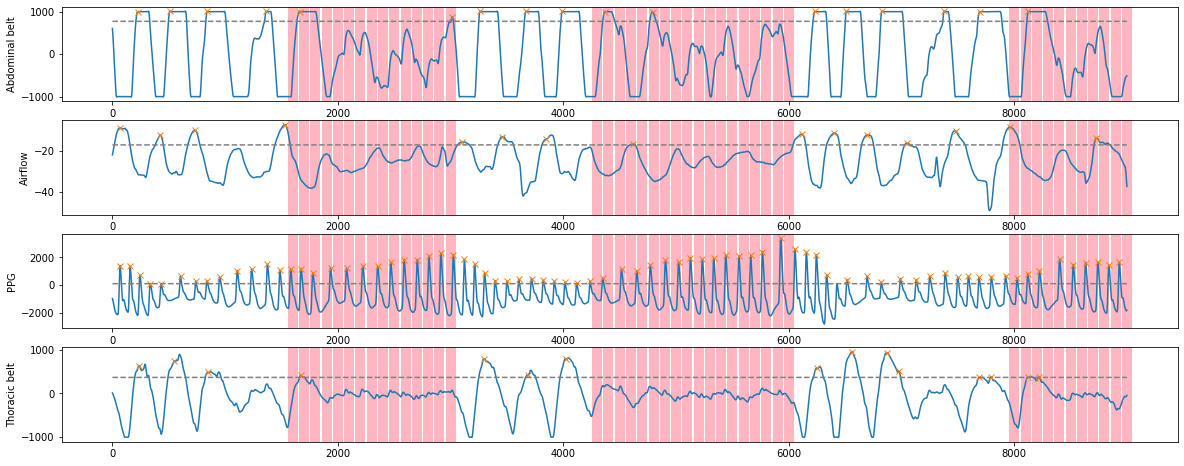

In [27]:
signal_id = idx_apnea_signals[500]
apneas_i = np.where(mask[signal_id] == 1)[0]

fig, ax = plt.subplots(nrows=4, figsize = (20,8))
for i in range(4):
    for idx in range(apneas_i.size):
        ax[i].axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
    signal_i = X_train[i, signal_id]
    ax[i].plot(signal_i)
    treshold = signal_i.mean()+ signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, time_peaks = keep_peaks(peaks, 0.6)
    print(f"Signal {i}")
    print(f"Average interval between peaks : {time_peaks.mean():.2f}, var : {time_peaks.var():.2f}, median : {np.median(time_peaks):.2f}, min : {time_peaks.min():.2f}, max : {time_peaks.max():.2f}  ")
    
    time_diff_peaks = []
    #peaks, _ = sg.find_peaks(signal_i,height=0)
    ax[i].plot(peaks, signal_i[peaks], "x")
    ax[i].plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
    ax[i].set_ylabel(labels[i])
    
    

In [29]:
def extract_features(signal_id, dim, n_window = 100, peak_param=1, time_treshold=0.5, plot=False):
    
    '''
    Returns matrix of shape 9000 which computes the distance to the closest peak, as well as the
    average value of the signal on a window of size n_window
    
    '''
    
    signal_i = X_train[dim, signal_id]
    treshold = signal_i.mean()+ peak_param*signal_i.std()
    peaks, _ = sg.find_peaks(signal_i,height=treshold)
    peaks, mean = keep_peaks(peaks, time_treshold)
    peaks = np.concatenate((peaks,np.asarray([signal_i.size-1])))
    
    dist_matrix = np.zeros((signal_i.size,2))
    mean_window = np.ones(n_window) / n_window
    peak_idx = 0
    
    for i in range(signal_i.size):
        dist_matrix[i,0] = (peaks[peak_idx] - i)/100
        
        if i == peaks[peak_idx]:
            peak_idx +=1 
    dist_matrix[:, 1] = np.convolve(signal_i, n_window, 'same' )
    
    
    if plot:
        fig, ax = plt.subplots(figsize=(20,5))
        apneas_i = np.where(mask[signal_id] == 1)[0]
        for idx in range(apneas_i.size):
            ax.axvline(apneas_i[idx]*100, color='#ffb6c1', linewidth=10)
        
        ax.plot(signal_i)
        ax.plot(peaks, signal_i[peaks], "x")
        ax.plot(np.zeros_like(signal_i)+treshold, "--", color="gray")
        ax.set_ylabel(labels[dim])
        
    
    return(dist_matrix)
        

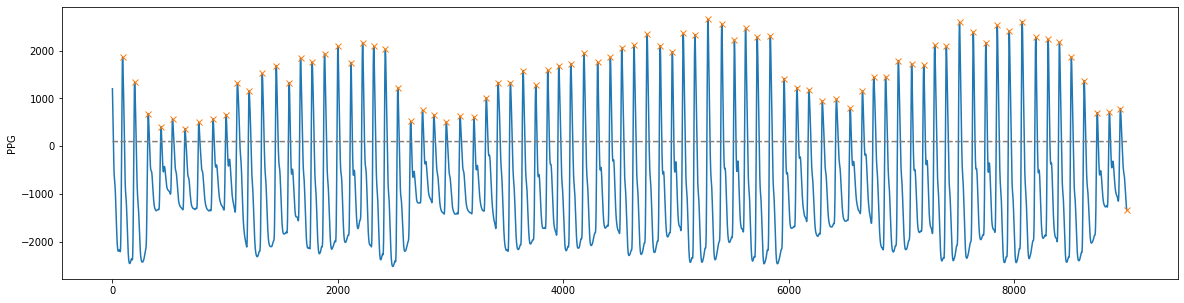

In [30]:
m = extract_features(324,2,peak_param=0.8, time_treshold=0.5, plot=True)

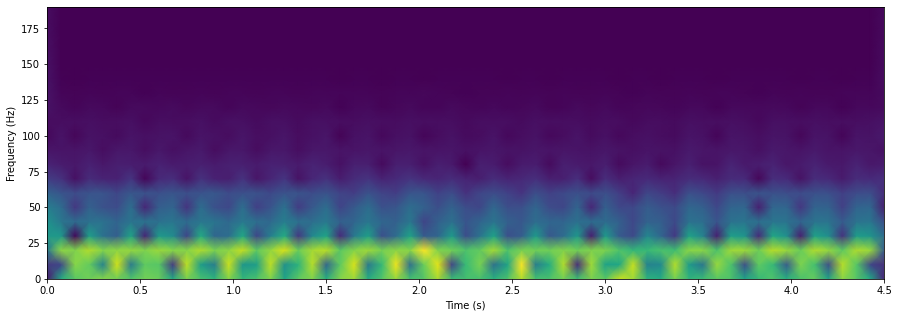

In [230]:
FREQUENCY = 100  # Hz
signal = X_train[2,2].flatten()
n_samples = 9000


# Cut-off frequency
cut_off_freq = 200  # Hz

fig, ax = fig_ax()

f, t, Zxx = sg.stft(signal, fs=FREQUENCY, nperseg=200, noverlap=50)

keep_mask = f < cut_off_freq

ax.pcolormesh(
    t, f[keep_mask], np.abs(Zxx[keep_mask]), vmin=0, shading="gouraud"
)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

In [32]:


FREQUENCY = 100


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def get_fourier_features(signal: np.ndarray, n_bins: int = 100) -> dict:
    """The signal is assumed to be centered and scaled to unit variance."""

    n_samples = signal.shape[0]
    fourier = abs(rfft(signal))
    freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)
    res_dict = dict()

    freq_bins = np.linspace(0, FREQUENCY / 2, n_bins + 1)
    for (f_min, f_max) in pairwise(freq_bins):
        keep = (f_min <= freqs) & (freqs < f_max)
        res_dict[f"fourier_{f_min:.1f}-{f_max:.1f}_Hz"] = np.log(
            np.sum(fourier[keep] ** 2)
        )
    return res_dict

In [33]:
get_fourier_features(signal_i, n_bins=20)

{'fourier_0.0-2.5_Hz': 30.54349558268909,
 'fourier_2.5-5.0_Hz': 25.60471769899346,
 'fourier_5.0-7.5_Hz': 23.48252829424743,
 'fourier_7.5-10.0_Hz': 19.1892286047873,
 'fourier_10.0-12.5_Hz': 17.636860198213157,
 'fourier_12.5-15.0_Hz': 17.140597500463638,
 'fourier_15.0-17.5_Hz': 16.69483008167704,
 'fourier_17.5-20.0_Hz': 16.461644424144584,
 'fourier_20.0-22.5_Hz': 16.220124604185212,
 'fourier_22.5-25.0_Hz': 15.995890084006945,
 'fourier_25.0-27.5_Hz': 15.861101805914906,
 'fourier_27.5-30.0_Hz': 15.716420923084751,
 'fourier_30.0-32.5_Hz': 15.577365975327384,
 'fourier_32.5-35.0_Hz': 15.500348808940918,
 'fourier_35.0-37.5_Hz': 15.415447187723402,
 'fourier_37.5-40.0_Hz': 15.331287821695884,
 'fourier_40.0-42.5_Hz': 15.2972945595002,
 'fourier_42.5-45.0_Hz': 15.258012684271039,
 'fourier_45.0-47.5_Hz': 15.215553800148589,
 'fourier_47.5-50.0_Hz': 15.219514444074909}